Chess Game Result Analysis - 401 Project

Berkay Yıldız - 201104087 

Zeynep Meriç Aşık - 201410026

# Importing the Dependencies

In [1]:
#!pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns

from random import random
import math
from pyspark import SparkContext
import re
from pyspark.sql import functions

In [3]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.conf import SparkConf

In [4]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier as RFC
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql.functions import isnan, when, count, col, isnull, concat_ws, split

In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [20]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [21]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
games = spark.read.format("csv").load("games.csv", header='true', inferSchema='true',  multiline = True)

In [47]:
games.show(1)

+--------+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+--------------------+-----------+--------------------+-----------+
|      id|rated|created_at|last_move_at|turns|victory_status|winner|increment_code|white_id|white_rating|black_id|black_rating|               moves|opening_eco|        opening_name|opening_ply|
+--------+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+--------------------+-----------+--------------------+-----------+
|TZJHLljE|false|1.50421E12|  1.50421E12|   13|     outoftime| white|          15+2|bourgris|        1500|    a-00|        1191|d4 d5 c4 c6 cxd5 ...|        D10|Slav Defense: Exc...|          5|
+--------+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+--------------------+-----------+--------------------+-----------+
only showing top 1 row



In [8]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- created_at: double (nullable = true)
 |-- last_move_at: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- increment_code: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [44]:
"""(games.describe().select(
                    "summary",
                    F.round("id", 4).alias("id"),
                    F.round("created_at", 4).alias("created_at"),
                    F.round("last_move_at", 4).alias("last_move_at"),
                    F.round("turns", 4).alias("turns"),
                    F.round("victory_status", 4).alias("victory_status"),
                    F.round("winner", 4).alias("winner"),
                    F.round("increment_code", 4).alias("increment_code"),
                    F.round("white_id", 4).alias("white_id"),
                    F.round("white_rating", 4).alias("white_rating"),
                    F.round("black_id", 4).alias("black_id"),
                    F.round("black_rating", 4).alias("black_rating"),
                    F.round("moves", 4).alias("moves"),
                    F.round("opening_eco", 4).alias("opening_eco"),
                    F.round("opening_name", 4).alias("opening_name"),
                    F.round("opening_ply", 4).alias("opening_ply"))
                    .show())"""
games.describe().toPandas()

,summary,id,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,count,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058
1,mean,None,1.483616852629092E12,1.4836177223361443E12,60.46599860404826,None,None,None,2.6775729307708335E9,1596.6318675840064,5.294535237863636E9,1588.8319872370128,None,None,None,4.8169807558081565
2,stddev,None,2.850150942100429E10,2.850140058889147E10,33.57058475353722,None,None,None,1.1283509443243038E10,291.253375737019,1.8875165053331074E10,291.03612596033423,None,None,None,2.7971518106301025
3,min,005lW0Xz,1.376771633173E12,1.376771863841E12,1,draw,black,0+12,--jim--,784,-0olo0-,789,Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...,A00,Alekhine Defense,1
4,max,zzcDhaYF,1.50449314379E12,1.504493827262E12,349,resign,white,90+8,zzzimon,2700,zztopillo,2723,h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...,E98,Zukertort Opening: Wade Defense,28


In [10]:
missing = games.select([count(when(isnull(c), c)).alias(c) for c in games.columns]).show()

+---+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
| id|rated|created_at|last_move_at|turns|victory_status|winner|increment_code|white_id|white_rating|black_id|black_rating|moves|opening_eco|opening_name|opening_ply|
+---+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
|  0|    0|         0|           0|    0|             0|     0|             0|       0|           0|       0|           0|    0|          0|           0|          0|
+---+-----+----------+------------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+



No missing (null) values.

# EDA

<AxesSubplot:xlabel='victory_status'>

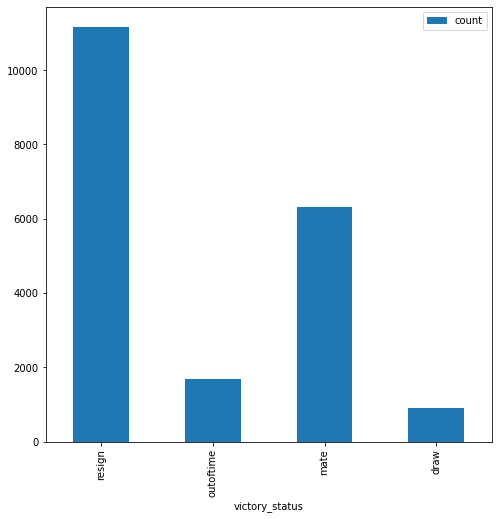

In [35]:
# group by victory status and see the distribution
result = games.groupBy("victory_status").count().sort("victory_status", ascending=False)
result.toPandas().plot.bar(x='victory_status',figsize=(8, 8))

<AxesSubplot:xlabel='winner'>

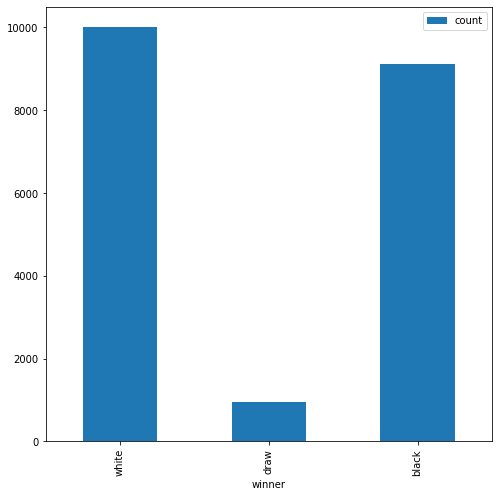

In [36]:
# group by winner and see the distribution
result = games.groupBy("winner").count().sort("winner", ascending=False)
result.toPandas().plot.bar(x='winner',figsize=(8, 8))

In [51]:
plt.figure(figsize = (11,11))
corr = games.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, cmap="viridis",linewidths = .6)
plt.title('Correlation Table')
plt.show()

TypeError: corr() missing 2 required positional arguments: 'col1' and 'col2'

<Figure size 792x792 with 0 Axes>

## Preprocessing the Data

In [50]:
games.select("id").dropDuplicates().sort("id").show()

+--------+
|      id|
+--------+
|005lW0Xz|
|009mKOEz|
|00R4UOcU|
|00dSgZj7|
|018JyEeA|
|019hqIVd|
|01C2scaa|
|01K0joz0|
|01PN8FTL|
|01PkUIzB|
|01SY3OrQ|
|01Y74mrM|
|01dkNQ2O|
|01pjlD76|
|02T5yk22|
|02V52u8v|
|02farjAR|
|03H8xiEz|
|03IUB5fo|
|03NoaOf5|
+--------+
only showing top 20 rows



In [11]:
dataset = games.select("*")

In [12]:
dataset = dataset.withColumn("rated_ind", when(col("rated") == True, 1).otherwise(0))

0 - FALSE  
1 - TRUE

In [13]:
dataset.groupBy("victory_status").agg({"victory_status": "sum"}).show()

+--------------+-------------------+
|victory_status|sum(victory_status)|
+--------------+-------------------+
|        resign|               NULL|
|     outoftime|               NULL|
|          mate|               NULL|
|          draw|               NULL|
+--------------+-------------------+



In [14]:
indexer = StringIndexer(inputCol="victory_status", outputCol="victory_status_ind")
dataset = indexer.fit(dataset).transform(dataset)

0 - resign  
1 - mate  
2 - out of time  
3 - draw

In [15]:
dataset.groupBy("winner").agg({"winner": "sum"}).show()

+------+-----------+
|winner|sum(winner)|
+------+-----------+
| white|       NULL|
| black|       NULL|
|  draw|       NULL|
+------+-----------+



In [16]:
indexer = StringIndexer(inputCol="winner", outputCol="winner_ind")
dataset = indexer.fit(dataset).transform(dataset)

0 - white  
1 - black  
2 - draw

In [17]:
dataset = dataset.withColumn("game_duration", (col("last_move_at") - col("created_at")).cast("double"))

In [18]:
columns_to_drop = ["id", "rated", "victory_status", "winner", "created_at", "last_move_at", "white_id", "black_id", "moves"]
dataset = dataset.drop(*columns_to_drop)

"id" column is dropped since it is does not provide information for analysis.
Our goal is to analyze the moves and its results, not the specific player's chess skills. So "white_id" and "black_id" columns are dropped, but their ratings remain.  
"created_at" and "last_move_at" columns are dropped and the difference was added to new column "game_duration".  
Other columns are dropped because they are stored in one hot form in different columns (_ind).  
Original dataset is stored in "games" dataframe. Preprocessed data will be used to perform analysis and prediction.  
TODO  
increment_code ??  
game_duration ???

In [19]:
dataset.show()

+-----+--------------+------------+------------+--------------------+-----------+--------------------+-----------+---------+------------------+----------+-------------+
|turns|increment_code|white_rating|black_rating|               moves|opening_eco|        opening_name|opening_ply|rated_ind|victory_status_ind|winner_ind|game_duration|
+-----+--------------+------------+------------+--------------------+-----------+--------------------+-----------+---------+------------------+----------+-------------+
|   13|          15+2|        1500|        1191|d4 d5 c4 c6 cxd5 ...|        D10|Slav Defense: Exc...|          5|        0|               2.0|       0.0|          0.0|
|   16|          5+10|        1322|        1261|d4 Nc6 e4 e5 f4 f...|        B00|Nimzowitsch Defen...|          4|        1|               0.0|       1.0|          0.0|
|   61|          5+10|        1496|        1500|e4 e5 d3 d6 Be3 c...|        C20|King's Pawn Game:...|          3|        1|               1.0|       0.0| 

## Data Analysis

In [14]:
#PCA ##########change code
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="turns", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(games)
data = scalerModel.transform(games)
data

TypeError: Invalid param value given for param "inputCol". Could not convert <class 'pyspark.sql.column.Column'> to string type

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(data)
pcaData = pcaModel.transform(data)

In [ ]:
explainedVariance = pcaModel.explainedVariance
print(explainedVariance)

## ML